<a href="https://colab.research.google.com/github/LuisManuelCatzoliSoriano/EDP-I/blob/main/Met_crank_nico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Método implícito de Crank-Nicolson**

Usaremos el método de diferencias finitas con $h=0.1$, $k=0.01$ para aproximar la solución de:

$ \frac{\partial}{\partial t} =\frac{\partial^2 }{\partial x^2}$, $0<x<1$, $t\geq 0$

Sujeto a las restricciones:

$u(0,t)=u(1,t)=0$, $0<t$, $u(x,0)=1-4(x-\frac{1}{2})^2$, $0\leq x \leq 1$

Sustituyendo las diferencias en la ecuación de calor y simplicando obtenemos, usando $r=\frac{\alpha^2k}{h}$:

$-ru_{i-1,j+1}+(2+2r)u_{i,j+1}-ru_{i+1,j+1}=ru_{i-1,j}+(2-2r)u_{i,j-1}$

Usando la igualdad anterior resolveremos el problema:

In [73]:
import sympy as sp
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para 3D
from matplotlib import cm  # colormap

+------+-------+--------+--------+--------+--------+--------+
|    t |   x=0 |    0.1 |    0.2 |    0.3 |    0.4 |    0.5 |
+======+=======+========+========+========+========+========+
| 0    |     0 | 0.36   | 0.64   | 0.84   | 0.96   | 1      |
+------+-------+--------+--------+--------+--------+--------+
| 0.01 |     0 | 0.3014 | 0.5657 | 0.7615 | 0.8804 | 0.9202 |
+------+-------+--------+--------+--------+--------+--------+
| 0.02 |     0 | 0.2676 | 0.5048 | 0.6885 | 0.803  | 0.8417 |
+------+-------+--------+--------+--------+--------+--------+
| 0.03 |     0 | 0.2399 | 0.4548 | 0.6231 | 0.73   | 0.7665 |
+------+-------+--------+--------+--------+--------+--------+
| 0.04 |     0 | 0.2164 | 0.411  | 0.5646 | 0.6626 | 0.6963 |
+------+-------+--------+--------+--------+--------+--------+
| 0.05 |     0 | 0.1958 | 0.3721 | 0.5117 | 0.6011 | 0.6319 |
+------+-------+--------+--------+--------+--------+--------+
| 0.06 |     0 | 0.1773 | 0.3372 | 0.4639 | 0.5452 | 0.5731 |
+------+

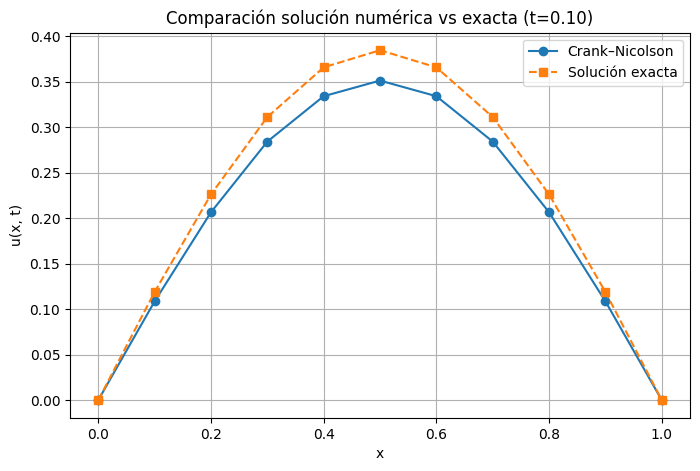


Error máximo = 0.03334911814482128
Error cuadratico     = 0.022485878172264898


In [94]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Parámetros
L = 1
h = 0.1
k = 0.01          # paso en t (igual que la tabla del libro)
r = k/(h*h)

x_vals = np.arange(0, L+h, h)
N = len(x_vals) - 2   # puntos interiores

# Condición inicial
def u0(x):
    return 1 - 4*(x - 0.5)**2

u_prev = np.array([u0(x) for x in x_vals])

# Construcción de matrices A y B del método Crank–Nicolson, para mí fue más fácil hacerlo de esta manera (I + r/2 * T) u^{n+1} = (I - r/2 * T) u^n

A = sp.zeros(N, N)
B = sp.zeros(N, N)

for i in range(N):
    for j in range(N):
        if i == j:
            A[i, j] = 1 + r
            B[i, j] = 1 - r
        elif abs(i - j) == 1:
            A[i, j] = -r/2
            B[i, j] = r/2

A = sp.Matrix(A)
A_inv = A.inv()
B = sp.Matrix(B)

# Función para avanzar un paso de tiempo
def crank_nicolson_step(u_prev):
    u_int = sp.Matrix(u_prev[1:-1])          # vector
    rhs = B * u_int                          # lado derecho
    u_next_int = A_inv * rhs                 # resolver sistema
    return np.array([0] + list(u_next_int) + [0], dtype=float)


# EJERCICIO 1:

t_max = 0.10
steps = int(t_max / k)

tabla = []
u = u_prev.copy()

for n in range(steps + 1):
    t = n * k
    fila = [f"{t:.2f}"] + [f"{u[i]:.4f}" for i in range(0, 6)]
    tabla.append(fila)
    u = crank_nicolson_step(u)

headers = ["t", "x=0", "0.1", "0.2", "0.3", "0.4", "0.5"]

print(tabulate(tabla, headers=headers, tablefmt="grid"))

# EJERCICIO 2: Comparación con solución exacta

# Solución exacta conocida:
# u(x,t) = sum_{n=1}^\infty b_n sin(nπx) exp(-n²π² t)
# donde b_n = 2 ∫_0^1 u0(x) sin(nπx) dx

x = sp.symbols("x")
u0_expr = 1 - 4*(x - sp.Rational(1,2))**2

def bn(n):
    return 2*sp.integrate(u0_expr*sp.sin(n*sp.pi*x), (x, 0, 1))

b_cache = {n: sp.N(bn(n)) for n in range(1, 40)}

def u_exact(x, t):
    s = 0
    for n in range(1, 40):
        s += b_cache[n] * np.sin(n*np.pi*x) * np.exp(-n*n*np.pi*np.pi*t)
    return float(s)


# comparar en t = 0.10
t_test = 0.10
u_num = u
u_real = np.array([u_exact(xi, t_test) for xi in x_vals])
error = np.abs(u_real - u_num)

plt.figure(figsize=(8,5))
plt.plot(x_vals, u_num, "o-", label="Crank–Nicolson")
plt.plot(x_vals, u_real, "s--", label="Solución exacta")
plt.title("Comparación solución numérica vs exacta (t=0.10)")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.show()

print("\nError máximo =", np.max(error))
print("Error cuadratico     =", np.sqrt(np.mean(error**2)))
